# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sb
import pickle

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.preprocessing import StandardScaler 
#TSNE
from sklearn.manifold import TSNE
from bs4 import BeautifulSoup


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Temporarily Suppressing Warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# [1]. Reading Data

In [3]:
# using the SQLite Table to read data.
# con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite')

con = sqlite3.connect('C:/Users/Saraswathi/Music/Appliedai/Data/amazon-fine-food-reviews/database.sqlite')

#filetering only positve and negative reviews
#reviews not taking in to consideration with score = 3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition( x ):
    if x > 3:
        return 1 #positive
#         return 1
    else:
        return 0 #negative

#changing reviews with score less than 3 to be positive and vice versa
actual_score = filtered_data['Score']
positivenegative = actual_score.map(partition)
filtered_data['Score']=positivenegative
print('Number of data point in our data',filtered_data.shape)
filtered_data.head(5)    

Number of data point in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""",con)

In [5]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending= True, inplace=False, kind ='quicksort',na_position='last')

In [7]:
#Duplication of entries
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep = 'first' , inplace= False)
final.shape

(19354, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions
    

In [9]:
display = pd.read_sql_query("""
SELECt * 
FROM Reviews
WHERE Score !=3 AND Id=44737 OR Id=64422
ORDER BY ProductId
""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [11]:
final.shape
final['Score'].value_counts()

1    16339
0     3015
Name: Score, dtype: int64

# Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [14]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
# for sentance in tqdm(final['Text'].values):
for sentance in final['Text'].values:
    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup(sentance,'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)  
    preprocessed_reviews.append(sentance.strip())

In [15]:
# Add pre processed reviews in to final df
# final['preprocessed_reviews'] = preprocessed_reviews

In [16]:
preprocessed_reviews[1000]

'received box great anticipation since not sell west coast got package opened box extremely disappointed cookies looked like gorilla shook box death left box filled crumbs rodent sized hole side box needless say not not reordering'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [17]:
##preprocessing for review summary also.

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
# for sentance in tqdm(final['Summary'].values):
for sentance in (final['Summary'].values):

    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup(sentance,'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)  
    preprocessed_summary.append(sentance.strip())

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


# Featurization

BAG OF WORDS, Bi-Grams and n-Grams, TF-IDF, Word2Vec, Converting text into vectors using wAvg W2V, TFIDF-W2V, Avg W2v, TFIDF weighted W2v

In [18]:
#storing label i.e positive and negative in another variable for tsne plot
labels = final['Score'] 




## BAG OF WORDS

In [19]:
#BOW
count_vect = CountVectorizer()
count_vect.fit(preprocessed_reviews)
print('some feature names are',count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words",final_counts.get_shape()[1])

some feature names are ['aa', 'aaaa', 'aaaaa', 'aaaand', 'aafco', 'aahhhs', 'aahs', 'ab', 'aback', 'abandon']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19354, 25997)
the number of unique words 25997


## Bi-Grams and n-Grams.

In [20]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
count_vect = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams",final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer (19354, 5000)
the number of unique words including both unigrams and bigrams 5000


## TF-IDF

In [21]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df =10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[:10])
print('='*50)
final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able give', 'able make', 'able order', 'able purchase']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (19354, 11762)
the number of unique words including both unigrams and bigrams  11762


##  Word2Vec

In [22]:
# Train your own Word2Vec model using your own text corpus
# i = 0
list_of_sentance = []
for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance)
    list_of_sentance.append(sentance.split())
# print((list_of_sentance))

In [23]:
# Using Google News Word2Vectors
is_your_ram_gt_16gb = False
want_to_use_google_w2v = True
want_to_train_w2v = True

# print(list_of_sentance)

if want_to_train_w2v:
   # min_count = 5 considers only words that occured atleast 5 times
    w2v_model = Word2Vec(list_of_sentance,min_count = 5 ,size = 50 ,workers = 4)
    print(type(w2v_model))
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    

elif want_to_use_google_w2v and is_your_ram_gt_16gb :
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary = True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")    



<class 'gensim.models.word2vec.Word2Vec'>
[('good', 0.8307294249534607), ('awesome', 0.820031464099884), ('excellent', 0.8074917793273926), ('wonderful', 0.7911520004272461), ('amazing', 0.7876395583152771), ('fantastic', 0.7802572846412659), ('decent', 0.7413613200187683), ('perfect', 0.6911841034889221), ('super', 0.6856997013092041), ('delicious', 0.685686469078064)]
[('personal', 0.8410727381706238), ('closest', 0.8388027548789978), ('hottest', 0.8318940997123718), ('awful', 0.8056787252426147), ('hooked', 0.8014079928398132), ('socks', 0.7952672839164734), ('reminded', 0.7942043542861938), ('disappointing', 0.7941983342170715), ('addicted', 0.7933684587478638), ('greatest', 0.7886935472488403)]


In [24]:
print(type(w2v_model))
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

<class 'gensim.models.word2vec.Word2Vec'>
number of words that occured minimum 5 times  8370
sample words  ['used', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product', 'available', 'traps', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully']


## Converting text into vectors using wAvg W2V, TFIDF-W2V


####  Avg W2v

In [25]:
#average word2vec
#compute average word2 vec for each review
sent_vectors = [];
# for sent in tqdm(list_of_sentance):
for sent in (list_of_sentance):
    
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words = 0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec  /=cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))        



19354
50


####  TFIDF weighted W2v

In [26]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(),list(model.idf_)))


In [27]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names()

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = [] ; # the tfidf-w2v for each sentence/review is stored in this list
row = 0
# for sent in tqdm(list_of_sentance):
for sent in (list_of_sentance):  
    sent_vec = np.zeros(50)
    weight_sum = 0; # as word vectors are of zero length
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
m        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## 1.1 Applying KNN - Brute force

### 1.1.1 Applying KNN brute force on BOW, SET1

#### Hyper parameter Tuning using Simple for loop

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score,auc

x = preprocessed_reviews
y = final['Score'].values

# print("shape of x is",type(x))
# print("shape of y is",type(y))

#tarin ,cv, test split
x1 , x_test, y1, y_test = train_test_split(x , y ,test_size =0.3,random_state = 0)
x_train, x_cv, y_train, y_cv = train_test_split(x1, y1, test_size = 0.3)


NameError: name 'preprocessed_reviews' is not defined

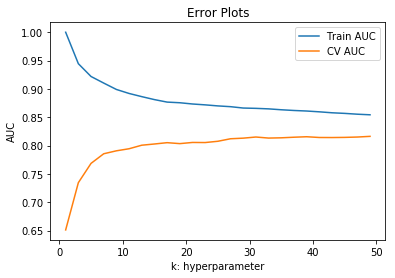

In [29]:
# Applying KNN brute force on BOW

cou_vec = CountVectorizer()
tran_x_train = cou_vec.fit_transform(x_train)
tran_x_cv = cou_vec.transform(x_cv)
tran_x_test = cou_vec.transform(x_test)

train_auc = []  
cv_auc = []

k = list(range(1,50,2))
for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform', algorithm = 'brute', leaf_size =30, p = 2, metric = 'cosine')
    knn.fit(tran_x_train,y_train)
    
    y_train_pred = knn.predict_proba(tran_x_train)[:,1]
    y_cv_pred = knn.predict_proba(tran_x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
plt.plot(k, train_auc,label = 'Train AUC')
plt.plot(k, cv_auc,label = 'CV AUC')
plt.legend()
plt.xlabel('k: hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.show()

#### Testing with Test data

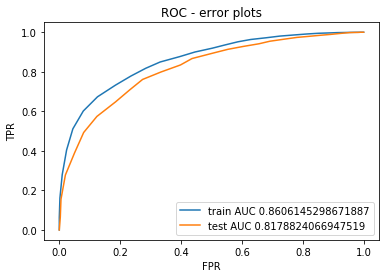

In [30]:
#ROC curve for k=40
#from above statistics we take k=49 as our best hyperparameter

knn = KNeighborsClassifier(n_neighbors= 40, weights= 'uniform',algorithm= 'brute', leaf_size= 30, p = 2, metric= 'cosine')

knn.fit(tran_x_train,y_train)
train_prob =  knn.predict_proba(tran_x_train)[:,1]
test_prob = knn.predict_proba(tran_x_test)[:,1]

# print('----------train_prob---')
# print(train_prob)
# print('----------y-train------')
# print(y_train)

#convert the y_train and y_test string in to 0 and 1
# y_train_labels = []
# for i in y_train:
#     if i == 'Positive':
#         y_train_labels.append(1)
#     else :
#         y_train_labels.append(0)



train_fpr, train_tpr, thresholds = metrics.roc_curve(y_train, train_prob )
test_fpr, test_tpr, thresholds1 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr ,train_tpr , label = 'train AUC '+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr , label = 'test AUC ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - error plots')
plt.legend()
plt.show()


#### Confusion Matrix

Train confusion matrix
[[ 334 1124]
 [ 111 7913]]
Test confusion matrix
[[ 158  741]
 [  99 4809]]


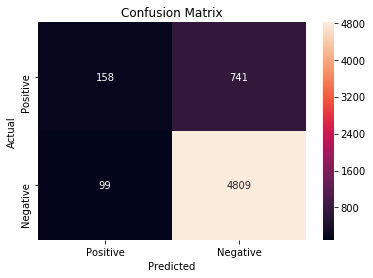

In [31]:
#Confusion Matrix

print('Train confusion matrix')
print(confusion_matrix(y_train, knn.predict(tran_x_train)))
print('Test confusion matrix')
print(confusion_matrix(y_test,knn.predict(tran_x_test)))

cnf_mat = confusion_matrix(y_test,knn.predict(tran_x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cnf_mat, index= class_labels , columns= class_labels)
sb.heatmap(df, annot= True, fmt= 'd')


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 1.1.2 Applying KNN brute force on TFIDF

#### Hyper parameter Tuning using Simple for loop

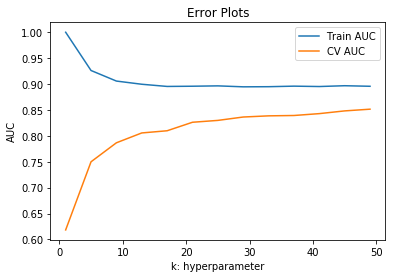

In [32]:
# Applying KNN brute force on TFIDF

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10)

tran_x_train = tf_idf_vect.fit_transform(x_train)
tran_x_cv = tf_idf_vect.transform(x_cv)
tran_x_test = tf_idf_vect.transform(x_test)

train_auc = []  
cv_auc = []

k = list(range(1,50,4))

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform', algorithm = 'brute', leaf_size =30, p = 2, metric = 'cosine')
    knn.fit(tran_x_train,y_train)
    
    y_train_pred = knn.predict_proba(tran_x_train)[:,1]
    y_cv_pred = knn.predict_proba(tran_x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
plt.plot(k, train_auc,label = 'Train AUC')
plt.plot(k, cv_auc,label = 'CV AUC')
plt.legend()
plt.xlabel('k: hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.show()

#### Testing with Test data

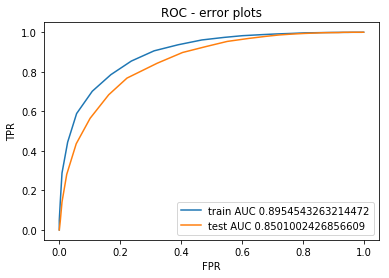

In [33]:
#ROC curve for k=39
#from above statistics we take k=49 as our best hyperparameter

knn = KNeighborsClassifier(n_neighbors= 39, weights= 'uniform',algorithm= 'brute', leaf_size= 30, p = 2, metric= 'cosine')

knn.fit(tran_x_train,y_train)
train_prob =  knn.predict_proba(tran_x_train)[:,1]
test_prob = knn.predict_proba(tran_x_test)[:,1]

train_fpr, train_tpr, thresholds = metrics.roc_curve(y_train, train_prob )
test_fpr, test_tpr, thresholds1 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr ,train_tpr , label = 'train AUC '+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr , label = 'test AUC ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - error plots')
plt.legend()
plt.show()


#### Confusion Matrix

Train confusion matrix
[[ 147 1311]
 [   8 8016]]
Test confusion matrix
[[  74  825]
 [   8 4900]]


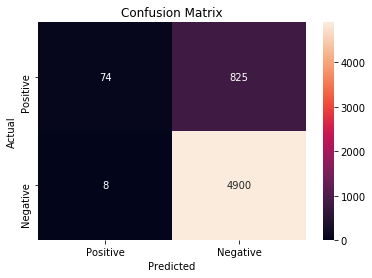

In [34]:
#Confusion Matrix

print('Train confusion matrix')
print(confusion_matrix(y_train, knn.predict(tran_x_train)))
print('Test confusion matrix')
print(confusion_matrix(y_test,knn.predict(tran_x_test)))

cnf_mat = confusion_matrix(y_test,knn.predict(tran_x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cnf_mat, index= class_labels , columns= class_labels)
sb.heatmap(df, annot= True, fmt= 'd')


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 1.1.3 Applying KNN brute force on avg W2V

#### Hyper parameter Tuning using Simple for loop

### Training w2v model

In [35]:
# w2v for train

#Preparing Reviews for gensim model

list_of_sentance_train = []
for sentance in x_train :
    list_of_sentance_train.append(sentance.split())
    
# Training w2v model
w2v_model = Word2Vec(list_of_sentance_train , min_count = 5, size = 50, workers =4)
w2v_words = list(w2v_model.wv.vocab)
print('no of words occured min 5 times ',len(w2v_words))
print("sample words ", w2v_words[0:50])


no of words occured min 5 times  5849
sample words  ['taste', 'surprisingly', 'good', 'would', 'compare', 'cross', 'sunflower', 'seeds', 'cashews', 'eat', 'plain', 'morning', 'found', 'blend', 'oatmeal', 'well', 'sugar', 'salt', 'combo', 'season', 'bad', 'soaked', 'water', 'washed', 'canister', 'air', 'dried', 'tasty', 'not', 'buy', 'mix', 'liquid', 'create', 'fat', 'free', 'peanut', 'butter', 'bought', 'use', 'green', 'smoothies', 'protein', 'shakes', 'purpose', 'stuff', 'great', 'get', 'nice', 'added', 'yogurt']


#### Converting Train data text

In [36]:

# Converting Reviews into Numerical Vectors using W2V vectors
## Algorithm: Avg W2V

# compute average word2vec for each review.
sent_vectors = []; #the average word2vec for each sentance/review will store in this list
# for sent in tqdm(list_of_sentance_train):
for sent in (list_of_sentance_train):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vec =  w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])


(9482, 50)
[-0.10015345 -0.13952778 -0.69643142 -0.22123822 -0.17367566 -0.21716264
  0.14167957  0.02430635  0.05191252  0.31244514 -0.1826644  -0.23223531
  0.25503365  0.81110474  0.03420242 -0.36973522  0.3336471  -0.00919806
 -0.36316538 -0.83581078  0.32639971  0.04406378  0.46400371  0.27717095
 -0.00772743  0.61218389 -0.09854228  0.3795618  -0.48292881  0.13612872
 -0.06617691  0.01175956 -0.76598121 -0.01519468 -0.03834009  0.15572058
 -0.29371912 -0.25373396  0.21663801 -0.21009477 -0.55682546 -0.44960642
  0.11176189 -0.73016817 -0.39343907  0.68043809  0.56688018 -0.43076087
 -0.14371563 -0.04545352]


#### Converting CV data text

In [37]:
list_of_sentance_cv = []
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; #the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance_cv):
for sent in (list_of_sentance_cv):
    
    sent_vec = np.zeros(50)
    cnt_words = 0 
    for word in sent: #for each word in a review/sentance
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])


(4065, 50)
[-0.56111266 -0.3301508  -0.49658867 -0.33143953 -0.03303619  0.03759975
  0.00461307  0.07727705 -0.16364837 -0.09558308  0.29497529 -0.08643394
  0.14915181  0.94391909 -0.21166885 -0.89522829  0.84734936 -0.49577404
 -0.62099049 -1.18628453 -0.12351938  0.08738138  0.45781254  0.0078997
  0.37790907  0.39231554  0.09007252  0.2302442  -0.52003445  0.13376317
  0.03520628 -0.01898587 -0.45706923  0.02258139 -0.01642686  0.15337167
 -0.56332976 -0.24369464  0.22561655 -0.09519706 -1.31305475 -0.29270774
 -0.44229863 -0.35368905 -0.49586512  0.4387508   0.23225555 -0.28374413
 -0.15746411 -0.70467384]


#### Testing with Test data

In [39]:
list_of_sentance_test = []
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [40]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; #the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance_test):
for sent in (list_of_sentance_test):

    sent_vec = np.zeros(50)
    cnt_words = 0 
    for word in sent: #for each word in a review/sentance
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])


(5807, 50)
[-1.36685390e-01 -3.16162983e-01 -7.33962582e-01 -9.77356889e-02
 -1.47434362e-01 -2.47024420e-01  1.60562633e-01  6.06824044e-02
  5.00919787e-02  4.12182803e-01 -2.04726054e-01 -3.64262811e-01
  3.92061047e-01  1.06030562e+00 -1.39883657e-01 -4.88527705e-01
  2.90301900e-01  8.66909002e-02 -4.21208843e-01 -7.52164311e-01
  4.07807537e-01  9.10700036e-02  4.70599352e-01  1.29679959e-01
  2.70348833e-02  6.51796704e-01 -7.79308185e-02  3.69570275e-01
 -2.96529363e-01  1.74088216e-01 -9.34901494e-02  4.80122896e-02
 -6.68169109e-01 -1.07261927e-01  9.38937896e-04  6.21475880e-02
 -2.31186979e-01 -2.29142259e-01  2.26058979e-01 -2.54717535e-01
 -7.57863260e-01 -3.60096508e-01  3.71860920e-01 -9.30603580e-01
 -4.96191480e-01  7.95541171e-01  7.37504847e-01 -3.18548126e-01
 -1.76443904e-01 -7.12061148e-02]


#### appliying KNN on avg W2V

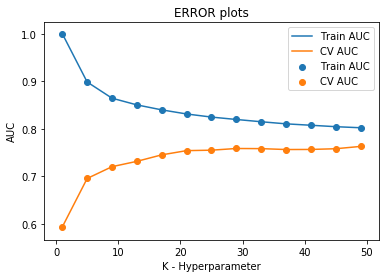

In [41]:
train_auc = []
cv_auc = []
k = range(1,50,4)

for i in k:
    knn = KNeighborsClassifier(n_neighbors= i, weights= 'uniform' ,algorithm='brute', leaf_size= 30, p = 2, metric= 'cosine')
    knn.fit(sent_vectors_train,y_train)
    y_train_pred = knn.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred = knn.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

plt.plot(k, train_auc,label ='Train AUC')
plt.scatter(k, train_auc, label = 'Train AUC')
plt.plot(k, cv_auc , label = 'CV AUC')
plt.scatter(k, cv_auc ,label = 'CV AUC')
plt.legend()
plt.xlabel('K - Hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR plots')
plt.show()
   


    

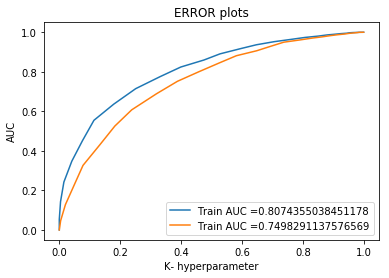

In [42]:
#from above statistics we take k=49 as our best hyperparameter
#ROC curve for k=41

knn = KNeighborsClassifier(n_neighbors= 41, weights= 'uniform', algorithm= 'brute',leaf_size= 30, p=2, metric= 'cosine')
knn.fit(sent_vectors_train,y_train)

train_fpr,train_tpr,tresholds = roc_curve(y_train, knn.predict_proba(sent_vectors_train)[:,1])
test_fpr,test_tpr,tresholds1 = roc_curve(y_test, knn.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label = 'Train AUC ='+ str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label = 'Train AUC ='+ str(auc(test_fpr,test_tpr)))


plt.legend()
plt.xlabel('K- hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR plots')
plt.show()

#### Confusion Matrix

Train confusion matrix
[[ 109 1349]
 [  56 7968]]
Test confusion matrix
[[  56  843]
 [  44 4864]]


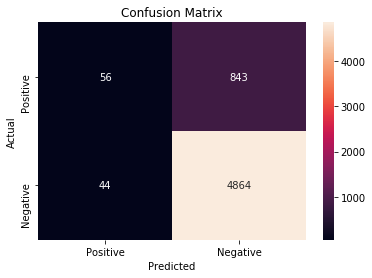

In [43]:
#Confusion Matrix

print('Train confusion matrix')
print(confusion_matrix(y_train, knn.predict(sent_vectors_train)))
print('Test confusion matrix')
print(confusion_matrix(y_test,knn.predict(sent_vectors_test)))

cnf_mat = confusion_matrix(y_test,knn.predict(sent_vectors_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cnf_mat, index= class_labels , columns= class_labels)
sb.heatmap(df, annot= True, fmt= 'd')


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 1.1.4 Applying KNN brute force on TFIDF W2V

#### Hyper parameter Tuning using Simple for loop

### Training w2v model

In [44]:
# w2v for train
# Preparing Reviews for gensim model

list_of_sentance_train = []
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())

w2v_model = Word2Vec(list_of_sentance_train , min_count = 5 ,size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)

In [45]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df= 10,max_features= 500)

tf_idf_matrix = tf_idf_vect.fit_transform(x_train)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))


#### Converting Train data text

In [46]:

tfidf_sent_vectors_train = []
row = 0

# for sent in tqdm(list_of_sentance_train):
for sent in (list_of_sentance_train):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#### Converting CV data


In [47]:
list_of_sentance_cv = []
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
    
tfidf_sent_vectors_cv = []
row = 0

# for sent in tqdm(list_of_sentance_cv):
for sent in (list_of_sentance_cv):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

#### Converting test data


In [48]:
list_of_sentance_test = []
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())
    
tfidf_sent_vectors_test = []
row = 0

# for sent in tqdm(list_of_sentance_test):
for sent in (list_of_sentance_test):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

#### appliying KNN on tfidf W2V

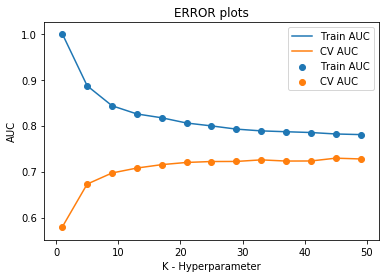

In [49]:
train_auc = []
cv_auc = []
k = range(1,50,4)

for i in k:
    knn = KNeighborsClassifier(n_neighbors= i, weights= 'uniform' ,algorithm='brute', leaf_size= 30, p = 2, metric= 'cosine')
    knn.fit(tfidf_sent_vectors_train,y_train)
    y_train_pred = knn.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred = knn.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

plt.plot(k, train_auc,label ='Train AUC')
plt.scatter(k, train_auc, label = 'Train AUC')
plt.plot(k, cv_auc , label = 'CV AUC')
plt.scatter(k, cv_auc ,label = 'CV AUC')
plt.legend()
plt.xlabel('K - Hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR plots')
plt.show()    

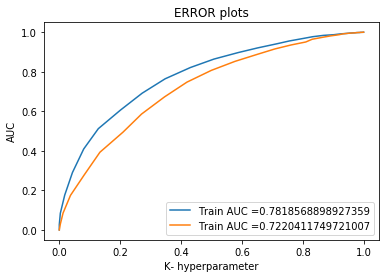

In [50]:
#from above statistics we take k=49 as our best hyperparameter
#ROC curve for k=45

knn = KNeighborsClassifier(n_neighbors= 45, weights= 'uniform', algorithm= 'brute',leaf_size= 30, p=2, metric= 'cosine')
knn.fit(tfidf_sent_vectors_train,y_train)

train_fpr,train_tpr,tresholds = roc_curve(y_train, knn.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr,test_tpr,tresholds1 = roc_curve(y_test, knn.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label = 'Train AUC ='+ str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label = 'Train AUC ='+ str(auc(test_fpr,test_tpr)))


plt.legend()
plt.xlabel('K- hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR plots')
plt.show()


#### Confusion Matrix

Train confusion matrix
[[  43 1415]
 [  16 8008]]
Test confusion matrix
[[  26  873]
 [  13 4895]]


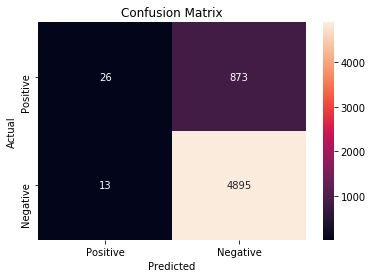

In [51]:
#Confusion Matrix
knn = KNeighborsClassifier(n_neighbors= i, weights= 'uniform' ,algorithm='brute', leaf_size= 30, p = 2, metric= 'cosine')
knn.fit(tfidf_sent_vectors_train,y_train)


print('Train confusion matrix')
print(confusion_matrix(y_train, knn.predict(tfidf_sent_vectors_train)))
print('Test confusion matrix')
print(confusion_matrix(y_test,knn.predict(tfidf_sent_vectors_test)))

cnf_mat = confusion_matrix(y_test,knn.predict(tfidf_sent_vectors_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cnf_mat, index= class_labels , columns= class_labels)
sb.heatmap(df, annot= True, fmt= 'd')


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## 1.2 Applying KNN kd-tree

#### 1.2.1 Applying KNN kd-tree on BOW

In [52]:

x = preprocessed_reviews
y = final['Score'].values

x = x[:20000]
y = y[:20000]

#tarin ,cv, test split
x1 , x_test, y1, y_test = train_test_split(x , y ,test_size =0.3,random_state = 0)
x_train, x_cv, y_train, y_cv = train_test_split(x1, y1, test_size = 0.3)


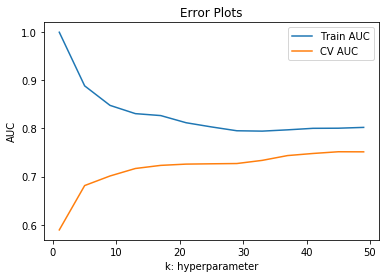

In [53]:
# Applying KNN brute force on BOW

cou_vec = CountVectorizer(min_df= 10 ,max_features= 500)
tran_x_train = cou_vec.fit_transform(x_train)
tran_x_cv = cou_vec.transform(x_cv)
tran_x_test = cou_vec.transform(x_test)

tran_x_train = tran_x_train.toarray()
tran_x_cv = tran_x_cv.toarray()
tran_x_test = tran_x_test.toarray()

train_auc = []  
cv_auc = []

k = list(range(1,50,4))
for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm = 'kd_tree')
    knn.fit(tran_x_train,y_train)
    
    y_train_pred = knn.predict_proba(tran_x_train)[:,1]
    y_cv_pred = knn.predict_proba(tran_x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
plt.plot(k, train_auc,label = 'Train AUC')
plt.plot(k, cv_auc,label = 'CV AUC')
plt.legend()
plt.xlabel('k: hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.show()

#### Testing with Test data

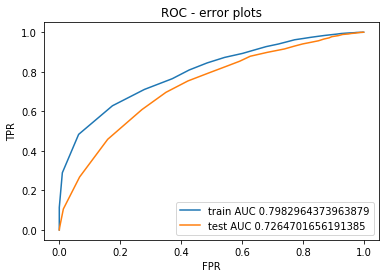

In [54]:
#ROC curve for k=40
#from above statistics we take k=40 as our best hyperparameter

knn = KNeighborsClassifier(n_neighbors= 40,algorithm= 'kd_tree')
knn.fit(tran_x_train,y_train)

train_prob =  knn.predict_proba(tran_x_train)[:,1]
test_prob = knn.predict_proba(tran_x_test)[:,1]

train_fpr, train_tpr, thresholds = metrics.roc_curve(y_train, train_prob )
test_fpr, test_tpr, thresholds1 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr ,train_tpr , label = 'train AUC '+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr , label = 'test AUC ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - error plots')
plt.legend()
plt.show()


#### Confusion Matrix

Train confusion matrix
[[ 192 1303]
 [ 130 7857]]
Test confusion matrix
[[  94  805]
 [ 110 4798]]


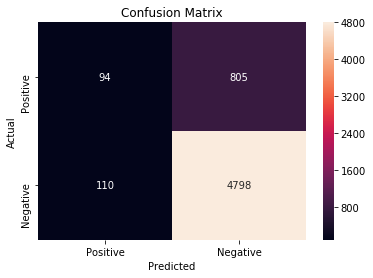

In [55]:
#Confusion Matrix

print('Train confusion matrix')
print(confusion_matrix(y_train, knn.predict(tran_x_train)))
print('Test confusion matrix')
print(confusion_matrix(y_test,knn.predict(tran_x_test)))

cnf_mat = confusion_matrix(y_test,knn.predict(tran_x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cnf_mat, index= class_labels , columns= class_labels)
sb.heatmap(df, annot= True, fmt= 'd')


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### 1.2.2 Applying KNN kd-tree on TFIDF

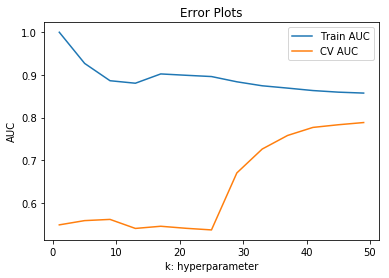

In [56]:
# Applying KNN brute force on BOW

cou_vec = TfidfVectorizer(ngram_range = (1,2), min_df= 10 ,max_features= 500)
tran_x_train = cou_vec.fit_transform(x_train)
tran_x_cv = cou_vec.transform(x_cv)
tran_x_test = cou_vec.transform(x_test)

tran_x_train = tran_x_train.toarray()
tran_x_cv = tran_x_cv.toarray()
tran_x_test = tran_x_test.toarray()

train_auc = []  
cv_auc = []

k = list(range(1,50,4))
for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm = 'kd_tree')
    knn.fit(tran_x_train,y_train)
    
    y_train_pred = knn.predict_proba(tran_x_train)[:,1]
    y_cv_pred = knn.predict_proba(tran_x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
plt.plot(k, train_auc,label = 'Train AUC')
plt.plot(k, cv_auc,label = 'CV AUC')
plt.legend()
plt.xlabel('k: hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.show()

#### Testing with Test data

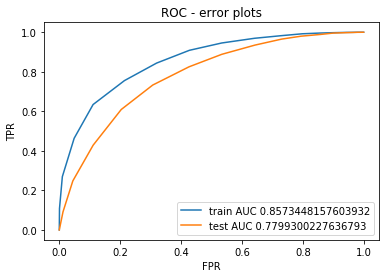

In [57]:
#ROC curve for k=49
#from above statistics we take k=49 as our best hyperparameter

knn = KNeighborsClassifier(n_neighbors= 49,algorithm= 'kd_tree')
knn.fit(tran_x_train,y_train)

train_prob =  knn.predict_proba(tran_x_train)[:,1]
test_prob = knn.predict_proba(tran_x_test)[:,1]

train_fpr, train_tpr, thresholds = metrics.roc_curve(y_train, train_prob )
test_fpr, test_tpr, thresholds1 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr ,train_tpr , label = 'train AUC '+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr , label = 'test AUC ' + str(auc(test_fpr,test_tpr)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - error plots')
plt.legend()
plt.show()


#### Confusion Matrix

Train confusion matrix
[[   0 1495]
 [   0 7987]]
Test confusion matrix
[[   0  899]
 [   0 4908]]


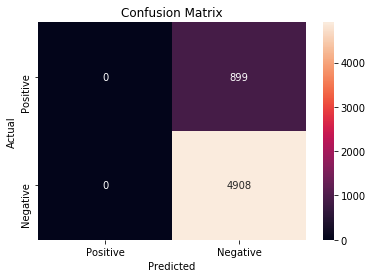

In [58]:
#Confusion Matrix

print('Train confusion matrix')
print(confusion_matrix(y_train, knn.predict(tran_x_train)))
print('Test confusion matrix')
print(confusion_matrix(y_test,knn.predict(tran_x_test)))

cnf_mat = confusion_matrix(y_test,knn.predict(tran_x_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cnf_mat, index= class_labels , columns= class_labels)
sb.heatmap(df, annot= True, fmt= 'd')


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 1.2.3 Applying KNN brute force on avg W2V

#### Hyper parameter Tuning using Simple for loop

### Training w2v model

In [59]:
# w2v for train

#Preparing Reviews for gensim model

list_of_sentance_train = []
for sentance in x_train :
    list_of_sentance_train.append(sentance.split())
    
# Training w2v model
w2v_model = Word2Vec(list_of_sentance_train , min_count = 5, size = 50, workers =4)
w2v_words = list(w2v_model.wv.vocab)
print('no of words occured min 5 times ',len(w2v_words))
print("sample words ", w2v_words[0:50])


no of words occured min 5 times  5805
sample words  ['saw', 'soup', 'supermarket', 'bought', 'opened', 'heated', 'tasted', 'dumped', 'drain', 'rinsed', 'mouth', 'enough', 'said', 'one', 'time', 'favorite', 'guilty', 'pleasure', 'sadly', 'nothing', 'left', 'enjoy', 'dry', 'flavorless', 'packing', 'peanuts', 'ya', 'know', 'gluten', 'free', 'diet', 'treats', 'like', 'licorice', 'milk', 'realizing', 'true', 'challenging', 'past', 'not', 'likely', 'ever', 'near', 'future', 'need', 'alter', 'expectations', 'treat', 'tried', 'company']


#### Converting Train data text

In [60]:

# Converting Reviews into Numerical Vectors using W2V vectors
## Algorithm: Avg W2V

# compute average word2vec for each review.
sent_vectors = []; #the average word2vec for each sentance/review will store in this list
# for sent in tqdm(list_of_sentance_train):
for sent in (list_of_sentance_train):
    
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vec =  w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])


(9482, 50)
[-0.11904924  0.05156635 -0.60322445  0.03610602 -0.10563253 -0.22966909
  0.15978353  0.09175231  0.01748197  0.10083751 -0.08661146 -0.12107145
  0.50575272  1.01908121 -0.17595667 -0.42173152  0.18356361 -0.2371283
 -0.15513094 -0.85932106  0.14766067  0.05484553  0.42585287 -0.04994882
  0.05210002  0.50240977  0.27376763  0.12884795 -0.16541266 -0.07342859
  0.03009616  0.04021095 -0.35042987  0.15206765 -0.26183085  0.04719124
 -0.39578848 -0.4489209   0.23585904 -0.25438966 -0.55938988 -0.17858979
  0.0668553  -0.40438684 -0.23498576  0.53756303  0.16899143 -0.23922266
 -0.07088466 -0.03865883]


#### Converting CV data text

In [61]:
list_of_sentance_cv = []
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())

In [62]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; #the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance_cv):
for sent in (list_of_sentance_cv):
    
    sent_vec = np.zeros(50)
    cnt_words = 0 
    for word in sent: #for each word in a review/sentance
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])


(4065, 50)
[ 1.08675488e-01 -5.18561995e-02 -9.76259550e-01 -4.86533377e-01
 -4.99798699e-01 -3.63610545e-01  4.10777079e-01 -6.55350553e-02
  1.86135224e-01  1.06740478e-01  2.16978657e-04 -3.40001163e-01
  6.52732973e-01  9.21373936e-01  1.56128782e-01 -5.42078413e-01
  6.06317628e-01 -3.67312523e-01 -5.55941803e-01 -1.29280666e+00
 -3.69713756e-02  6.20774879e-02  5.93800420e-01  2.42623178e-01
  2.47707098e-01  9.81328165e-01  1.75006762e-01  4.84737765e-01
 -3.10388692e-01  1.58953508e-01 -6.40440612e-03 -2.63417226e-02
 -7.94731795e-01  1.68729715e-01 -2.65882980e-01  4.55308142e-01
 -5.24880229e-01 -1.44571070e-01  6.64029636e-01 -4.93892945e-03
 -9.28271315e-01 -4.21585944e-01 -4.34136733e-01  1.28186260e-01
 -6.61514573e-01  6.12255279e-01  1.79673382e-01 -4.70354701e-01
 -2.26046517e-01  3.45528575e-01]


#### Testing with Test data

In [63]:
list_of_sentance_test = []
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [64]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; #the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance_test):
for sent in (list_of_sentance_test):
    
    sent_vec = np.zeros(50)
    cnt_words = 0 
    for word in sent: #for each word in a review/sentance
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])


(5807, 50)
[-0.12582644 -0.12281049 -0.88252326 -0.09540953 -0.29049125 -0.22267107
  0.15071908  0.16505331  0.06357586  0.35074272 -0.16103913 -0.25343732
  0.60182804  1.24713718 -0.22794516 -0.53399829  0.18482541  0.03090353
 -0.24134272 -0.90466988  0.29802347  0.12790198  0.57920605 -0.05689662
 -0.00320583  0.76965249  0.20169412  0.22055938 -0.19950745  0.11746916
  0.00544813 -0.04978439 -0.67059739  0.03233894 -0.28367862  0.09616763
 -0.32848275 -0.38669969  0.444644   -0.13702084 -0.6683806  -0.299794
  0.25817729 -0.64164366 -0.35535353  0.75326924  0.31471238 -0.30255095
 -0.18184619  0.09029683]


#### appliying KNN on avg W2V

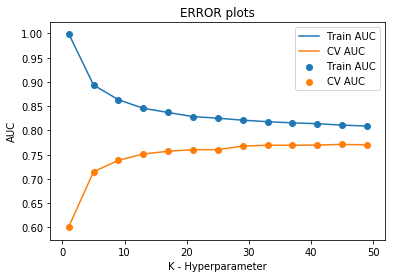

In [65]:
train_auc = []
cv_auc = []
k = range(1,50,4)

for i in k:
    knn = KNeighborsClassifier(n_neighbors= i, algorithm='kd_tree')
    knn.fit(sent_vectors_train,y_train)
    y_train_pred = knn.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred = knn.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

plt.plot(k, train_auc,label ='Train AUC')
plt.scatter(k, train_auc, label = 'Train AUC')
plt.plot(k, cv_auc , label = 'CV AUC')
plt.scatter(k, cv_auc ,label = 'CV AUC')
plt.legend()
plt.xlabel('K - Hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR plots')
plt.show()

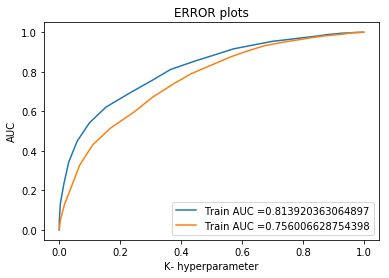

In [66]:
#from above statistics we take k=49 as our best hyperparameter
#ROC curve for k=41

knn = KNeighborsClassifier(n_neighbors= 41,algorithm= 'kd_tree')
knn.fit(sent_vectors_train,y_train)

train_fpr,train_tpr,tresholds = roc_curve(y_train, knn.predict_proba(sent_vectors_train)[:,1])
test_fpr,test_tpr,tresholds1 = roc_curve(y_test, knn.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label = 'Train AUC ='+ str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label = 'Train AUC ='+ str(auc(test_fpr,test_tpr)))


plt.legend()
plt.xlabel('K- hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR plots')
plt.show()

#### Confusion Matrix

Train confusion matrix
[[ 105 1390]
 [  37 7950]]
Test confusion matrix
[[  43  856]
 [  24 4884]]


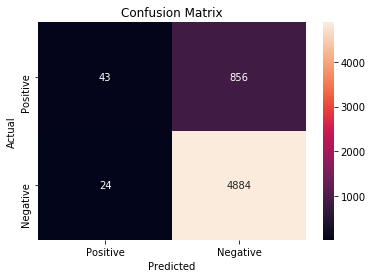

In [67]:
#Confusion Matrix

print('Train confusion matrix')
print(confusion_matrix(y_train, knn.predict(sent_vectors_train)))
print('Test confusion matrix')
print(confusion_matrix(y_test,knn.predict(sent_vectors_test)))

cnf_mat = confusion_matrix(y_test,knn.predict(sent_vectors_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cnf_mat, index= class_labels , columns= class_labels)
sb.heatmap(df, annot= True, fmt= 'd')


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 1.2.4 Applying KNN brute force on TFIDF W2V

#### Hyper parameter Tuning using Simple for loop

### Training w2v model

In [68]:
# w2v for train
# Preparing Reviews for gensim model

list_of_sentance_train = []
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())

w2v_model = Word2Vec(list_of_sentance_train , min_count = 5 ,size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)

In [69]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df= 10,max_features= 500)

tf_idf_matrix = tf_idf_vect.fit_transform(x_train)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))


#### Converting Train data text

In [70]:

tfidf_sent_vectors_train = []
row = 0

# for sent in tqdm(list_of_sentance_train):
for sent in (list_of_sentance_train):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#### Converting CV data


In [71]:
list_of_sentance_cv = []
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
    
tfidf_sent_vectors_cv = []
row = 0

# for sent in tqdm(list_of_sentance_cv):
for sent in (list_of_sentance_cv):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

#### Converting test data


In [72]:
list_of_sentance_test = []
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())
    
tfidf_sent_vectors_test = []
row = 0

# for sent in tqdm(list_of_sentance_test):
for sent in (list_of_sentance_test):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

#### appliying KNN on tfidf W2V

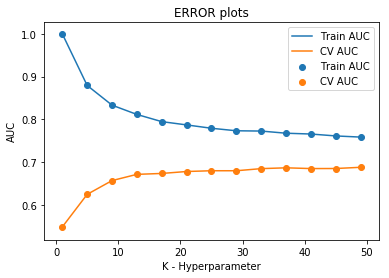

In [73]:
train_auc = []
cv_auc = []
k = range(1,50,4)

for i in k:
    knn = KNeighborsClassifier(n_neighbors= i,algorithm='kd_tree')
    knn.fit(tfidf_sent_vectors_train,y_train)
    y_train_pred = knn.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred = knn.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

plt.plot(k, train_auc,label ='Train AUC')
plt.scatter(k, train_auc, label = 'Train AUC')
plt.plot(k, cv_auc , label = 'CV AUC')
plt.scatter(k, cv_auc ,label = 'CV AUC')
plt.legend()
plt.xlabel('K - Hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR plots')
plt.show()

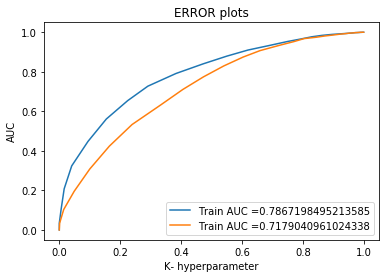

In [74]:
#from above statistics we take k=49 as our best hyperparameter
#ROC curve for k=41

knn = KNeighborsClassifier(n_neighbors= 41, weights= 'uniform', algorithm= 'brute',leaf_size= 30, p=2, metric= 'cosine')
knn.fit(tfidf_sent_vectors_train,y_train)

train_fpr,train_tpr,tresholds = roc_curve(y_train, knn.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr,test_tpr,tresholds1 = roc_curve(y_test, knn.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label = 'Train AUC ='+ str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label = 'Train AUC ='+ str(auc(test_fpr,test_tpr)))


plt.legend()
plt.xlabel('K- hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR plots')
plt.show()


#### Confusion Matrix

Train confusion matrix
[[  13 1482]
 [   3 7984]]
Test confusion matrix
[[   6  893]
 [   3 4905]]


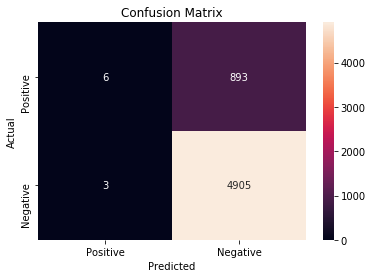

In [75]:
#Confusion Matrix
knn = KNeighborsClassifier(n_neighbors= i,algorithm='kd_tree')
knn.fit(tfidf_sent_vectors_train,y_train)


print('Train confusion matrix')
print(confusion_matrix(y_train, knn.predict(tfidf_sent_vectors_train)))
print('Test confusion matrix')
print(confusion_matrix(y_test,knn.predict(tfidf_sent_vectors_test)))

cnf_mat = confusion_matrix(y_test,knn.predict(tfidf_sent_vectors_test))
class_labels = ['Positive','Negative']
df = pd.DataFrame(cnf_mat, index= class_labels , columns= class_labels)
sb.heatmap(df, annot= True, fmt= 'd')


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# [6] Conclusions

In [77]:
# compare all your models 
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Vectorizer','Model','Hyperameter','AUC']
x.add_row(['BOW','Brute',49,0.81])
x.add_row(['TFIDF','Brute',49,0.85])
x.add_row(['AvgW2V','Brute',49,0.74])
x.add_row(['TFIDF W2V','Brute',41,0.72])
x.add_row(['BOW','Kd Tree',49,0.72])
x.add_row(['TFIDF','Kd Tree',49,0.77])
x.add_row(['AvgW2V','Kd Tree',49,0.75])
x.add_row(['TFIDF W2V','Kd Tree',41,0.71])
print(x)

+------------+---------+-------------+------+
| Vectorizer |  Model  | Hyperameter | AUC  |
+------------+---------+-------------+------+
|    BOW     |  Brute  |      49     | 0.81 |
|   TFIDF    |  Brute  |      49     | 0.85 |
|   AvgW2V   |  Brute  |      49     | 0.74 |
| TFIDF W2V  |  Brute  |      41     | 0.72 |
|    BOW     | Kd Tree |      49     | 0.72 |
|   TFIDF    | Kd Tree |      49     | 0.77 |
|   AvgW2V   | Kd Tree |      49     | 0.75 |
| TFIDF W2V  | Kd Tree |      41     | 0.71 |
+------------+---------+-------------+------+
